# Probabilistic Land Cover Segmentation

If you are working with this notebook in a Google Colab Notebook environment, don't forget to change the Runtime to GPU.

In [1]:
%pip install lightning-uq-box
%pip install torchgeo
%pip install opencv-python

  Using cached timm-0.9.16-py3-none-any.whl.metadata (38 kB)
Using cached timm-0.9.16-py3-none-any.whl (2.2 MB)
  Attempting uninstall: timm
    Found existing installation: timm 0.9.2
    Uninstalling timm-0.9.2:
      Successfully uninstalled timm-0.9.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
segmentation-models-pytorch 0.3.3 requires timm==0.9.2, but you have timm 0.9.16 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
  Using cached timm-0.9.2-py3-none-any.whl.metadata (68 kB)
Using cached timm-0.9.2-py3-none-any.whl (2.2 MB)
  Attempting uninstall: timm
    Found existing installation: timm 0.9.16
    Uninstalling timm-0.9.16:
      Successfully uninstalled timm-0.9.16
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the

This notebook will demonstrate the use of a probabilistic Unet as introduced by [Kohl et al. 2018](https://arxiv.org/abs/1806.05034) for the task of land cover segmentation. Additionally, we will compare that to a Bayesian Neural Network, with partially stochastic layers as layed out by [Sharma et al. 2023](https://arxiv.org/abs/2211.06291). We will use the LoveDA Dataset ([Wang et al. 2021](https://arxiv.org/abs/2110.08733)) that can be downloaded and used via the [TorchGeo](https://github.com/microsoft/torchgeo). The dataset consists of 8 classes and for a quick overview you can check the [TorchGeo docs](https://torchgeo.readthedocs.io/en/stable/api/datasets.html#loveda).

## Imports

In [1]:
import os
import tempfile
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchseg
from huggingface_hub import hf_hub_download
from lightning import Trainer
from lightning.pytorch.loggers import CSVLogger
from torch import Tensor
from torchgeo.datamodules import LandCoverAIDataModule

from lightning_uq_box.uq_methods import (
    BNN_VI_ELBO_Segmentation,
    DeterministicSegmentation,
    ProbUNet,
)
from lightning_uq_box.viz_utils import plot_training_metrics

%load_ext autoreload
%autoreload 2

/opt/anaconda3/envs/devuqbox/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Datamodule

We will slightly adapt the Datamodule to add some training augmentations and resizing, and will set the datamodule to use the validation set as our final test dataloader as well.

In [2]:
datamodule = LandCoverAIDataModule(
    root="/mnt/SSD2/nils/projects/flood_mapping_uq/data/landcover", batch_size=64
)
datamodule.setup("fit")

In [3]:
# normalization collate function for separate dataloaders
def collate_fn(batch):
    """Collate function for normalization."""
    images = torch.stack([item["image"] for item in batch])
    labels = torch.stack([item["mask"] for item in batch])
    return datamodule.aug({"image": images, "mask": labels})


val_dataloader = datamodule.val_dataloader()
val_dataloader.collate_fn = collate_fn

## Model

For our probabilistic Unet we will use the [torchseg library](https://github.com/isaaccorley/torchseg) that supports Unet architectures with a huge selection of [timm library](https://github.com/huggingface/pytorch-image-models) encoders.

In [13]:
prob_unet = ProbUNet(
    model=torchseg.Unet(
        encoder_name="resnet18", classes=5, in_channels=3, encoder_weights="imagenet"
    ),
    optimizer=partial(torch.optim.Adam, lr=1e-3),
    beta=1000,
    latent_dim=16,
)

# the data keys from torchgeo are called 'image' and 'mask'
prob_unet.input_key = "image"
prob_unet.target_key = "mask"

We have done the model training beforehand, so you don't have to wait for training. If you want to play around with the model training set `USE_CHECKPOINT=False`.

In [14]:
# download the checkpoint from huggingface

filename = "landcoverai_prob_unet_resnet18.ckpt"
hf_hub_download(
    repo_id="lightning-uq-box/land_cover_segmentation_notebook",
    filename=filename,
    local_dir=".",
)

ckpt_path = os.path.join(os.getcwd(), filename)

# load checkpoint
prob_unet = ProbUNet.load_from_checkpoint(ckpt_path, model=prob_unet.model)

# the data keys from torchgeo are called 'image' and 'mask'
prob_unet.input_key = "image"
prob_unet.target_key = "mask"

USE_CHECKPOINT = True

RuntimeError: Error(s) in loading state_dict for ProbUNet:
	size mismatch for prior.conv_layer.weight: copying a param with shape torch.Size([32, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([12, 192, 1, 1]).
	size mismatch for prior.conv_layer.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([12]).
	size mismatch for posterior.conv_layer.weight: copying a param with shape torch.Size([32, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([12, 192, 1, 1]).
	size mismatch for posterior.conv_layer.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([12]).
	size mismatch for fcomb.layers.0.weight: copying a param with shape torch.Size([32, 21, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 11, 1, 1]).

In [7]:
base_dir = tempfile.mkdtemp()

trainer = Trainer(
    devices=[0],
    accelerator="gpu",
    default_root_dir=base_dir,
    max_epochs=50,
    logger=CSVLogger(base_dir),
    log_every_n_steps=1,
    enable_progress_bar=True,
)

# evaluate or finetune pretrained model
if not USE_CHECKPOINT:
    trainer.fit(prob_unet, datamodule=datamodule)

/opt/anaconda3/envs/devuqbox/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/anaconda3/envs/devuqbox/lib/python3.11/site-pac ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


If you trained the model, you can inspect some training metrics with the following cell.

In [8]:
if USE_CHECKPOINT:
    pass
else:  # plot training and val metrics
    fig = plot_training_metrics(
        os.path.join(base_dir, "lightning_logs"),
        ["train_loss", "train_Jaccard", "val_loss", "val_Jaccard"],
    )

We can test the model on the validation set to inspect results.

In [9]:
if USE_CHECKPOINT:
    trainer.test(model=prob_unet, ckpt_path=ckpt_path, datamodule=datamodule)
else:
    trainer.test(model=prob_unet, ckpt_path="best")

You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /tmp/tmp7_k5owrp/lightning_logs
Restoring states from the checkpoint path at /mnt/SSD2/nils/lightning-uq-box/docs/tutorials/earth_observation/loveda_prob_unet_resnet18.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
Loaded model weights from the checkpoint at /mnt/SSD2/nils/lightning-uq-box/docs/tutorials/earth_observation/loveda_prob_unet_resnet18.ckpt
/opt/anaconda3/envs/devuqbox/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argume

Testing DataLoader 0: 100%|██████████| 53/53 [01:20<00:00,  0.66it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        testF1Score        │     0.656725287437439     │
│        testJaccard        │    0.49502310156822205    │
└───────────────────────────┴───────────────────────────┘

## Example Visualizations

In [8]:
import matplotlib.patches as mpatches

cmap = datamodule.train_dataset._lc_cmap
classes = ["Background", "Building", "Woodland", "Water", "Road"]


def plot_random_sample(
    preds: dict[str, Tensor], images: Tensor, targets: Tensor
) -> None:
    """Plot a random segmentation sample from the prediction batch.

    Args:
        preds: dictionary containing 'pred' and 'pred_uct'
        images: tensor of input images
        targets: segmentation mask target
    """
    # Select a random index from the prediction batch
    idx = np.random.randint(len(images))

    # Get the prediction set for the selected sample
    mean_preds = preds["pred"][idx].argmax(dim=0).numpy()
    pred_uct = preds["pred_uct"][idx].numpy()

    # Get the corresponding class labels for the prediction set
    # pred_labels = [class_labels[i] for i in pred_set]
    true_label = targets[idx]

    image = images[idx].permute(1, 2, 0).numpy()

    fig, ax = plt.subplots(1, 4, figsize=(16, 4))

    # plot the input image
    ax[0].imshow(image)
    ax[0].set_title("Input Image")
    ax[0].axis("off")

    # plot the prediction
    ax[1].imshow(mean_preds, vmin=0, vmax=4, cmap=cmap, interpolation="none")
    ax[1].set_title("Mean Prediction")
    ax[1].axis("off")

    # plot the uncertainty with cmap='hot'
    im = ax[2].imshow(pred_uct, cmap="jet")
    fig.colorbar(im, ax=ax[2])
    # show cmap legend

    ax[2].set_title("Uncertainty (Entropy)")
    ax[2].axis("off")

    # plot the target
    ax[3].imshow(true_label, vmin=0, vmax=4, cmap=cmap, interpolation="none")
    ax[3].set_title("Target")
    ax[3].axis("off")

    # Create legend
    legend_patches = [
        mpatches.Patch(color=cmap.colors[i], label=classes[i])
        for i in range(len(classes))
    ]
    ax_legend = fig.add_axes([0.1, -0.1, 0.8, 0.1])  # Adjust the values as needed
    ax_legend.legend(
        handles=legend_patches, loc="center", ncol=len(classes), fontsize=14
    )
    ax_legend.axis("off")

    # Plot the input image
    # Plot the prediction set
    plt.tight_layout()
    plt.show()

In [6]:
predict_batch = next(iter(val_dataloader))

In [76]:
prob_unet.to("cpu")
with torch.no_grad():
    preds = prob_unet.predict_step(predict_batch["image"])

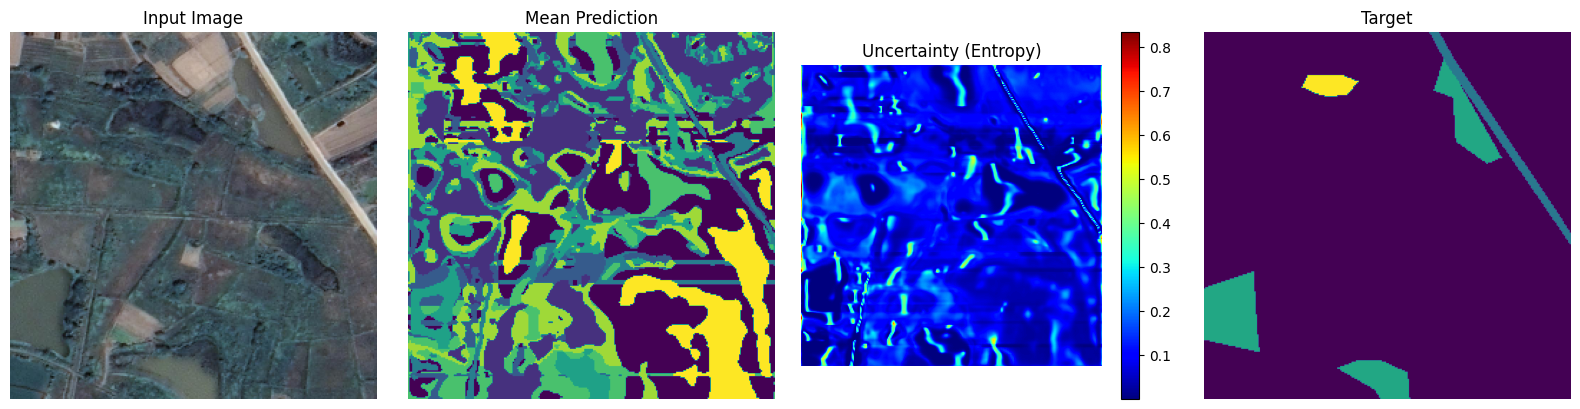

In [78]:
plot_random_sample(preds, predict_batch["image"], predict_batch["mask"])

## Bayesian Neural Network 

As a comparison we will define a Bayesian Segmentation Unet with only a selected number of layers being Bayesian.

In [84]:
bnn_model = BNN_VI_ELBO_Segmentation(
    model=torchseg.Unet(
        encoder_name="resnet18", encoder_weights="imagenet", classes=8, in_channels=3
    ),
    criterion=torchseg.losses.DiceLoss(mode="multiclass"),
    num_mc_samples_train=5,
    beta=100,
    stochastic_module_names=[
        "decoder.blocks.4.conv1.0",
        "decoder.blocks.4.conv2.0",
        "segmentation_head.0",
    ],  # these layers will be bayesian
)

In [85]:
filename = "loveda_bnn_resnet18.ckpt"
hf_hub_download(
    repo_id="lightning-uq-box/loveda_bnn_resnet18", filename=filename, local_dir="."
)

ckpt_path = os.path.join(os.getcwd(), filename)

# load checkpoint
prob_unet = BNN_VI_ELBO_Segmentation.load_from_checkpoint(
    ckpt_path, model=bnn_model.model, criterion=bnn_model.criterion
)

# the data keys from torchgeo are called 'image' and 'mask'
prob_unet.input_key = "image"
prob_unet.target_key = "mask"

USE_CHECKPOINT = True

AttributeError: module 'lightning_uq_box.models.bnn_layers' has no attribute 'Conv2dVariationalVariational'

In [20]:
predict_batch = next(iter(val_dataloader))

In [71]:
preds = bnn_model.predict_step(predict_batch["image"])

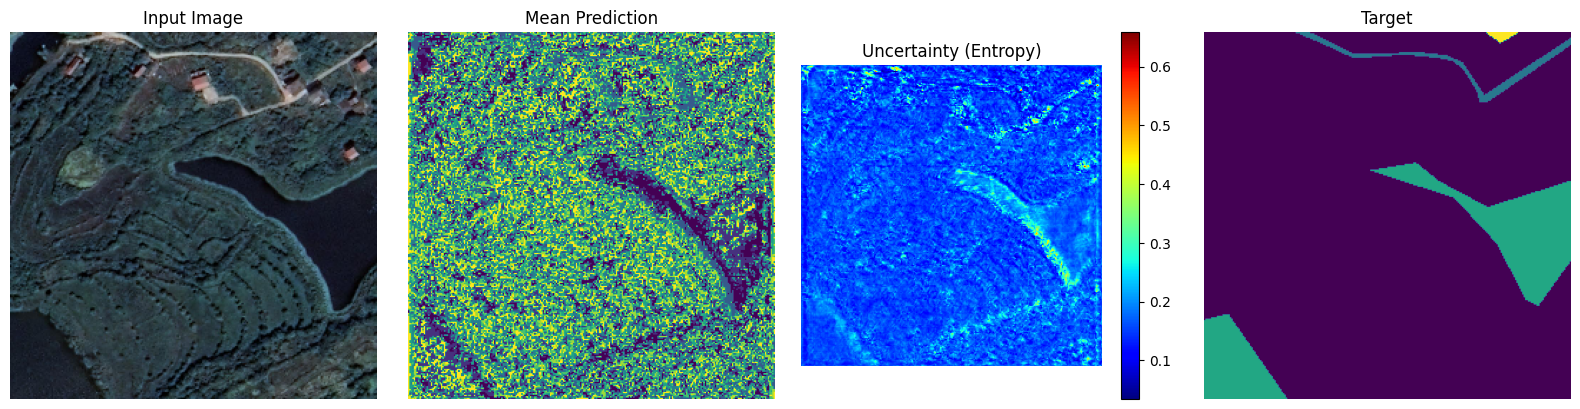

In [72]:
plot_random_sample(preds, predict_batch["image"], predict_batch["mask"])

## Deterministic Model

In [4]:
det_model = DeterministicSegmentation(
    model=torchseg.Unet(
        encoder_name="resnet18", encoder_weights="imagenet", classes=5, in_channels=3
    ),
    # loss_fn=nn.CrossEntropyLoss(weight=torch.tensor([0.5793, 0.0086, 0.3313, 0.0646, 0.0162])),
    loss_fn=torchseg.losses.JaccardLoss(mode="multiclass"),
)

In [5]:
filename = "lancoverai_det_resnet18.ckpt"
hf_hub_download(
    repo_id="lightning-uq-box/land_cover_segmentation_notebook",
    filename=filename,
    local_dir=".",
)

ckpt_path = os.path.join(os.getcwd(), filename)

ckpt_path = "/mnt/SSD2/nils/projects/flood_mapping_uq/src/lcai_experiments/lcai_DeterministicSegmentation_04-24-2024_19-13-35-444657/epoch=119-step=14040.ckpt"

# load checkpoint
det_model = DeterministicSegmentation.load_from_checkpoint(
    ckpt_path, model=det_model.model, loss_fn=det_model.loss_fn
)

# the data keys from torchgeo are called 'image' and 'mask'
det_model.input_key = "image"
det_model.target_key = "mask"

USE_CHECKPOINT = True

In [6]:
predict_batch = next(iter(val_dataloader))

In [7]:
det_model.to("cpu")
preds = det_model.predict_step(predict_batch["image"])

/tmp/ipykernel_3702106/2311036245.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


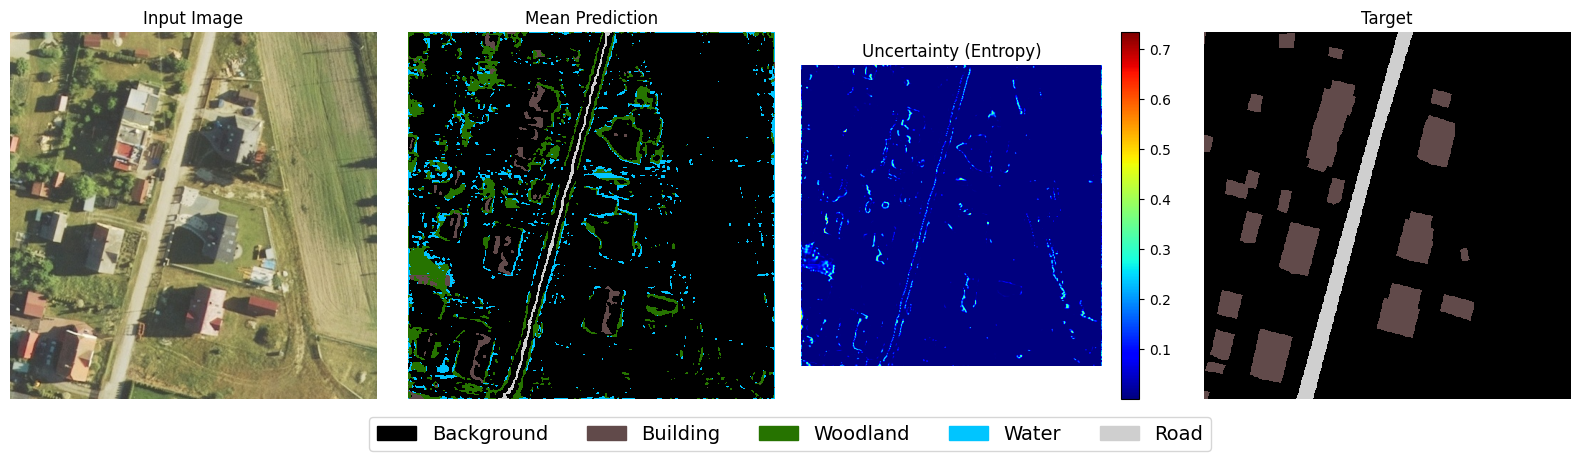

In [27]:
plot_random_sample(preds, predict_batch["image"], predict_batch["mask"])

In [28]:
predict_batch["image"].shape

torch.Size([64, 3, 512, 512])

: 